# Implementing paper: Rain or Snow Detection in Image Sequences Through Use of a Histogram of Orientation Streaks

2011

## Below is the implementation of the math from section 2.1


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#rain parameters
a=1   #size of a rain drop in mm anything between 0.5 and 5 mm (for hailstone 10-40mm)
rho=30  #rain density anything under 305 mm/hour or 38mm/min
v=200*np.sqrt(a) #maybe velocity: 2-10 m/s (for hailstone 10-20m/s)

#camera parameters
f=35  #camera focal length 10-1200mm
N=2.8 #F-Number between f/1.4–f/22
Te = 0.5 #exposure time 1/16000-1s
Lb = 500 #background brightness 0.0001 - 100.000
Lr = 750 #rain brightness
fpixel = f*0.5 #focal length in pixels
#mixed parameters
Zm = 2*fpixel*a #the distance after which rain becomes fog for a camera
z = 20 #distance of rain drop from camera
#rain visible region 0<z<R*Zm where R is a constant
#R depends on the brightness of the scene and camera sensitivity

def G(f,N):
    return f*N

vr_aprox = ((a ^ 2) * np.sqrt(rho) / np.sqrt(v))*(Lr-Lb)*((np.sqrt( G(f,N) ) ) / np.sqrt(Te) )
print vr_aprox



4066.63251352


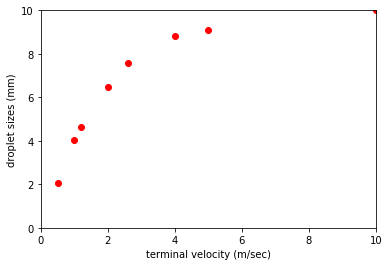

In [30]:

plt.plot([0.5,2.0,1.0,2.6,1.2,4.0,5.0,10,40],[2.06,6.49,4.03,7.57,4.64,8.83,9.09,10,20],'ro')
plt.axis([0,10,0,10])
plt.ylabel("droplet sizes (mm)")
plt.xlabel("terminal velocity (m/sec)")
plt.show()

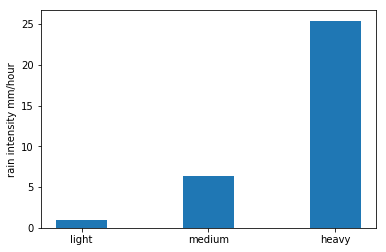

In [54]:
rain_intensities = [1.016,6.35,25.4] #mm/hour
#plt.hist(rain_intensities, normed=True, bins=3)
plt.bar([2,4,6],rain_intensities)
plt.xticks([2,4,6],["light","medium","heavy"])
plt.ylabel("rain intensity mm/hour")
plt.show()

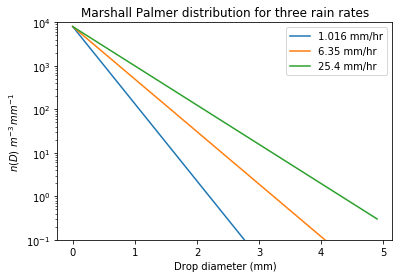

In [55]:
def marshall_dist(Dvec,RR):
  """
     Calcuate the Marshall Palmer drop size distribution

     Input: Dvec: vector of diameters in mm
            RR: rain rate in mm/hr
     output: n(Dvec), length of Dvec, in m^{-3} mm^{-1}
  """
  N0=8000  #m^{-3} mm^{-1}
  the_lambda= 4.1*RR**(-0.21)
  output=N0*np.exp(-the_lambda*Dvec)
  return output

Dvec=np.arange(0,5,0.1) #mm
rr_1=marshall_dist(Dvec,rain_intensities[0])
rr_5=marshall_dist(Dvec,rain_intensities[1])
rr_25=marshall_dist(Dvec,rain_intensities[2])

fig=plt.figure(1)
fig.clf()
ax1=fig.add_subplot(111)
ax1.semilogy(Dvec,rr_1,label=str(rain_intensities[0])+' mm/hr')
ax1.semilogy(Dvec,rr_5,label=str(rain_intensities[1])+' mm/hr')
ax1.semilogy(Dvec,rr_25,label=str(rain_intensities[2])+' mm/hr')
ax1.set_xlabel('Drop diameter (mm)')
ax1.set_ylabel('$n(D)\ m^{-3}\,mm^{-1}$')
ax1.set_title('Marshall Palmer distribution for three rain rates')
ax1.set_ylim([0.1,1.e4])
ax1.legend()
fig.savefig('marshall_palmer.png')
plt.show()

### Johnsons Criteria

The minimum required resolution according to Johnson's criteria are expressed in terms of line pairs of image resolution across a target, in terms of several tasks:[2]
* Detection, an object is present (1.0 +/− 0.25 line pairs)
* Orientation, symmetrical, asymmetric, horizontal, or vertical (1.4 +/− 0.35 line pairs)
* Recognition, the type object can be discerned, a person versus a car (4 +/− 0.8 line pairs)
* Identification, a specific object can be discerned, a woman versus a man, the specific car (6.4 +/− 1.5 line pairs)

These amounts of resolution give a 50 percent probability of an observer discriminating an object to the specified level.
Additionally, the line pairs refer to lines being displayed on an interlaced CRT monitor. Each line pair corresponds to 2 pixels of a film image, or an image displayed on an LCD monitor.

### Where did i read about pixels-on-target?

### Mapping between camera parameters and Johnsons Criteria

Total Horizontal Resolution / Pixels per mm = Field of View
pixel / pixel/mm = pixel*mm 

### Calculating the distance based on the Johnsons Criteria

 Calculating the distance using a segment of a circle requires a different formula.
 
C= circumference

S= segment of the circumference

A= angle of the lens

R = distance (or radius of the circle)
 
To calculate the radius (distance) using the segment method, we use the formula C=2πr.
Since a 30-degree segment of the circle is 1/12 of 360-degrees we need to calculate the circumference using the following formula:

C= S x 360/A

In this case C= 24 ft.  x 360/30 = 24 x 12 = 288 ft. (87.8 m)

Now we have the circumference, we can calculate the radius:

C/(2π) = R

288/(2 x 3.14) = 45.9 ft. (14 m)


5.26315789474
232.23889296


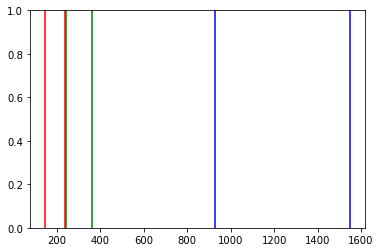

In [35]:


#pixels on target according to the Johnsons Criteria optimistic an pessimistic pixels
detection = [2*(1.0-0.25),2*(1.0+0.25)] #in pixels
recognition = [2*(4-0.8),2*(4+0.8)]
identification = [2*(6.4-1.5),2*(6.4+1.5)]

#assume for a car I need horizontal pixels
car_detection = 10
car_recognition = 20
car_identification = 40


distance_to_car = 50 #m

car_length = 4.7 #m
car_width = 1.9 #m
car_angle = 0 #between 0 and 180

pixels_meter = car_detection/car_width 
print pixels_meter #this number of pixels per meter are needed to identify a car

camera_lens_angle = 30 #degrees
image_width = 640 #pixels horizontal
image_height = 480 #pixels

field_of_view = image_width/pixels_meter #

C = field_of_view*360/camera_lens_angle
R = C/(2*np.pi)
print R

def getDistance(target):
    return (image_width/(target/car_width))*360/camera_lens_angle/(2*np.pi)

dd_o = getDistance(detection[0])
dd_p = getDistance(detection[1])
rd_o = getDistance(recognition[0])
rd_p = getDistance(recognition[1])
id_o = getDistance(identification[0])
id_p = getDistance(identification[1])

plt.axvline(dd_o,color='b')
plt.axvline(dd_p,color='b')
plt.axvline(rd_o,color='g')
plt.axvline(rd_p,color='g')
plt.axvline(id_o,color='r')
plt.axvline(id_p,color='r')
plt.show()
#the plot shows the detection,recognition,identification ranges in meters 


## Section 2.2

Each pixel of the image is modelled  by a mixture of K Gaussian distributions.


In [16]:


K = 100 # munber of Gaussian distributions for each pixel
Time = 30 #time = the sum of all available pictures that will be analyzed
total_Pixels = 640*480

P = [[0 for x in range(total_Pixels)] for y in range(t)] # our actual images collected as a array of pixel for each timestamp
omega = [[0 for x in range(K)] for y in range(t)]
mu = [[0 for x in range(K)] for y in range(t)]
sigma = [[0 for x in range(K)] for y in range(t)]
M = [[0 for x in range(K)] for y in range(t)]
#initialize M as such: M[k,t] = 1 if omega[k] is the first matched component, 0 otherwise
X = [for y in range(t)]

#mu is the mean, sigma is the standard deviation of the kth gaussian component, X is a pixel at time t
def Gaussian_N(X,mu,sigma):
    return 1/(sigma*np.sqrt(2*np.pi))*np.e^((-1/2)*(sigma^(-2))*(X-mu)^2)

T = 0.3 #minimum prior probability of observing a background pixel
gamma_1 = 0.001 #decay factor
change_factor = 1/gamma_1 #time constant which determines change
b = 5 # b < K a subset of the total gaussian distributions used as a model of the scene background
B = [[0 for x in range(total_Pixels)] for y in range(b)] #this will be our background
F = [[0 for x in range(total_Pixels)] for y in range(t)] #these will be our foregrounds of movement


#for one timestamp
for t in range(Time):
    #for one pixel
    for i in range(total_Pixels):
        
        temp_sum = 0
        #for one Gaussian distribution
        for k in range(K):
            temp_sum += omega[k][t]*Gaussian_N(P[i][t],mu[k][t],sigma[k][t])
            fitness_value = omega[k][t]/sigma[k][t]
            #this should be moved in a prior loop
            if k <= b and k>0:
                temp_sum2 = 0
                for j in range(1,B)
                    temp_sum2+=omega[j][t]
                B[i][k]=np.argmin(temp_sum2>T) #not sure if this is correct, look at page 351
            if t>1:
                rho = gamma_1*Gaussian_N(X[t]|mu[k][t],omega[k][t])
                omega[k][t]=(1-gamma_1)*omega[k][t-1]+gamma_1*M[k][t]
                mu[k][t] = (1-rho)*mu[k][t-1]+rho*X[t]
                sigma[k][t] = np.sqrt((1-rho)*np.sqr(sigma[k][t-1])+rho*np.sqr(X[t]-mu[k,t]))

        P[i][t] = temp_sum
        
        D = 3 #pixel intensity multiplier
        for x in range(b):
            isForeground = False
            if P[i][t]>B[i][x]*D
                isForeground = True
        if(isForeground)
            F[i][t] = 1 #marked as foreground



49497.4746831


### Explanation of above code

We take all the P images collected use the first B images to make a model of our background.
We go through all T images taken at different times and mark pixels as foreground if they are more than D times intense as the standard deviation from any of the B distributions

We end up with F which has the same size as P only now at each timestamp we have a binary image where 0 = background pixel and 1 = foreground pixel

## Next steps (Sections 2.3 and 2.4)

After we separate our foreground from our background we apply two selection rules:
* Photometric selection rule 2.3
* Size selection rule 2.4



~~~~
Flood-fill (node, target-color, replacement-color):
 1. If target-color is equal to replacement-color, return.
 2. If color of node is not equal to target-color, return.
 3. Set Q to the empty queue.
 4. Add node to Q.
 5. For each element N of Q:
 6.         Set w and e equal to N.
 7.         Move w to the west until the color of the node to the west of w no longer matches target-color.
 8.         Move e to the east until the color of the node to the east of e no longer matches target-color.
 9.         For each node n between w and e:
10.             Set the color of n to replacement-color.
11.             If the color of the node to the north of n is target-color, add that node to Q.
12.             If the color of the node to the south of n is target-color, add that node to Q.
13. Continue looping until Q is exhausted.
14. Return.
~~~~

In [ ]:
Image = [for x in range(total_Pixels)]

def flood_fill(node,target_color,replacement_color):
    if target_color==replacement_color:
        return node
    if node.color!=target_color:
        return node
    Q = Queue.Empty
    Q.put(node)
    for N in Q:
        w = N
        e = N
        #move W to the west while the target_color==w.color
        while(target_color==w.color): w = w.west
        while(target_color==e.color): e = e.east
        for n in range(w,e)
            n.color = replacement_color
            if(n.north==taget_color): Q.put(n.north)
            if(n.south==target_color): Q.put(n.south)
    return node
    
    

In [ ]:
#Section 2.3 Photometric Rule

n = 0 # n is the index of an image taken 0 < n < T
c = 0 # a threshold that represents the minimum transient change in intensity caused 
isPhotoRuleSat = False
# I is the intensity
delta_I_1 = I[n][t]-I[n-1][t]
delta_I_2 = I[n][t]-I[n+1][t]
if delta_I_1<0:
    delta_I_1=-delta_I_1
if delta_I_2<0:
    delta_I_2=-delta_I_2
if delta_I_1==delta_I_2 and delta_I_1>=c:
    isPhotoRuleSat = True

#Section 2.4 Size Selection Rule
#only explained in words, no math to work with
#filter out objects that are too large or too small
#use a flood-fill algorithm and then suppress the connected components whose size is not plausible
#for each foreground image in F use flood-fill
#then remove components that span too many pixels
#make a heuristic for separating the big objects versus the small objects




## Construction of the HOS (Histogram of orientation streaks)

Implementing Section 3.2




In [ ]:
#TODO check soft-voting algorithm, looks like a ML classifier multiple classifiers and vote on the best

bins = 180
P_blobs = 300 # total number of blobs possibly the ones from the foreground
hist = [0 for x in range(bins)]
w = [0 for x in range(P_blobs)] #weight
theta = [0 for x in range(P_blobs)] # angles from 0 to pi
d = [0 for x in range(P_blobs)] #uncertainty on the estimation

#update histogram here
temp_sum = 0
for i in range(P_blobs):
    temp_sum = w[i]*Gaussian_N(theta,theta[i],d[i])
hist[theta] = temp_sum



### Section 3.3

Making the HOS

In [ ]:
#parameters related to each segmented blob from section 3.2
a = [0 for i in range(P_blobs)] #major semiaxis
b = [0 for i in range(P_blobs)] #short semiaxis
orientation_d_theta = [0 for i in range(P_blobs)]
x0 = 0
y0 = 0
gravity_center = [x0,y0] #gravity center
theta_hos = [0 for i in range(P_blobs)] #tilt angle
m = [[0 for i in range(4)] for j in range(P_blobs)] #4 values for each of the P_blobs equivalent to m00,m02,m11,m20 in this order
x = [0 for i in range(P_blobs)]
y = [0 for i in range(P_blobs)]
#second order moments?

m20_sum = 0
m11_sum = 0
m02_sum = 0
# the lambdas are eigenvalues of the matrix given by the 2x2 matrix of ((m20,m11)(m11,m02)) <=> ((m[3][i],m[2][i])(m[2][i],m[1][i]))
lambda_1 = [0 for i in range(P_blobs)]
lambda_2 = [0 for i in range(P_blobs)]
for i in range(P_blobs):
    m20_sum += (x[i]-x0)^2
    m11_sum += (x[i]-x0)*(y[i]-y0)
    m02_sum += (y[i]-y0)^2

dm =0 #chosen empirically by performing tests in simulation (Section 3.4)    

for i in range(P_blobs):

    m[3][i] = 1/m[0][i]*m20_sum
    m[2][i] = 1/m[0][i]*m11_sum
    m[1][i] = 1/m[0][i]*m02_sum
    a[i] = np.sqrt(lambda_1[i])
    b[i] = np.sqrt(lambda_2[i])
    theta_hos[i] = 1/2*np.arctan(2*m[3][i]/(m[1][i]-m[3][i]))
    orientation_d_theta[i] = np.sqrt((m[1][i]-m[3][i])^2+2*(m[2][i])^2)/((m[1][i]-m[3][i])^2+4*(m[2][i])^2)*dm
    
#The contribution of elongated ellipses to the HOS is a peaky Gaussian distribution
#The contribution of ellipses with shapes close to disks is a flat Gaussian distribution
#The HOS expression:
theta_single_value = 0 #TODO investigate what this is?
hos = 0
for i in range(P_blobs):
    hos+= a[i]/orientation_d_theta[i]*np.sqrt(2*np.pi)*np.exp((-1/2)*((theta_single_value-theta_hos[i]))/orientation_d_theta[i])^2


## Section 3.4 
Used to understand the value dm from section 3.3


In [ ]:
#Rain streak related parameters for evaluation of HOG and HOS
w_s = 1 #the width in pixels
l_s = 11 #the length in pixels
mu_s = 55 #the mean value in degrees
sigma_s = 10 # standard deviation in degrees

#measure the mean value and standard deviation at the peak of the HOS on different simulated images
mu_m = 0
sigma_m = 0
#relative errors on the mean and on the stan dev
mu_f = 0 #it doesn't say what these values are
sigma_f = 0 #it doesn't say what these values are
epsilon_mu = (mu_f - mu_m) / mu_f
epsilon_sigma = (sigma_f - sigma_m) / sigma_f




## Section 4
### 4.1 Model

Rain streaks have an orientation which follows a Gaussian distribution.
How to model the noise?

In [ ]:
theta = np.pi/2 # range between [0,PI]
#y(theta)*d*theta the probability of observing [theta,theta+d*theta]
capital_pi = 0 #the surface of the Gaussian distribution
# mean mu and stan dev sigma U[0,pi](theta) = uniform distribution on the interval [0,pi]
#HOS is modelled as a Gaussian Uniform Distribution see page 354 equation 23


### 4.2 Estimation of Model Parameters

In [ ]:
# Use an Expectation maximization algorithm


### Section 5

Uses a Kalman filter to compute a temporary smoothed model of the HOS

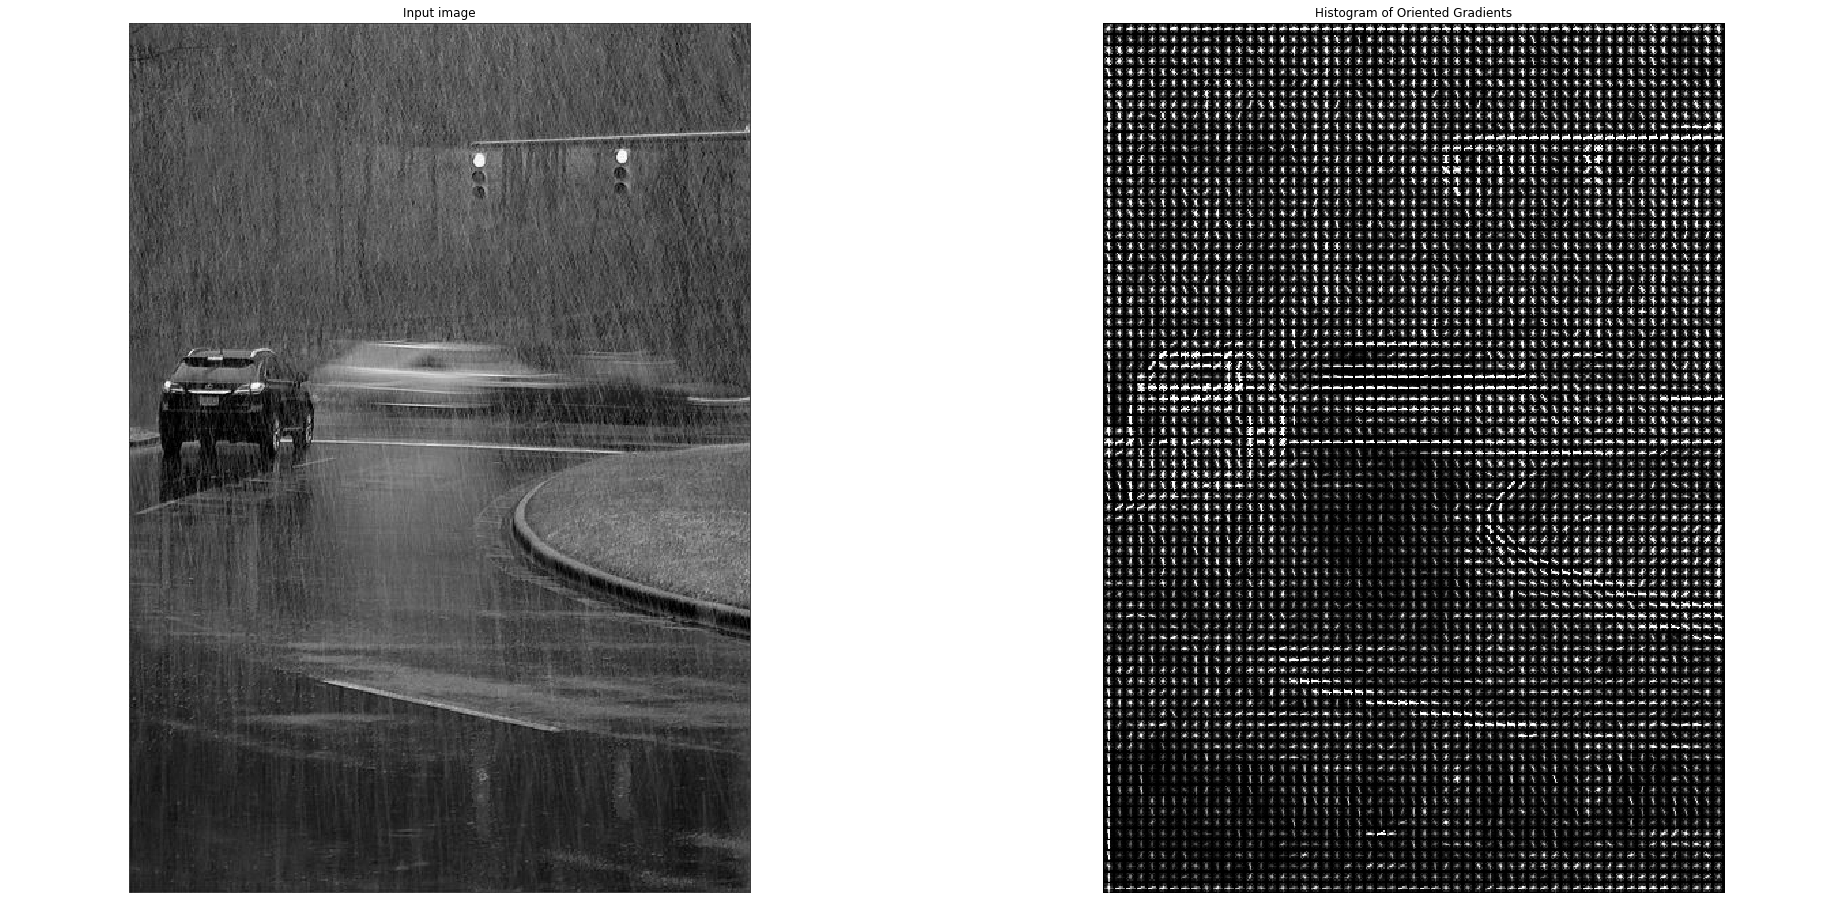

In [17]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, color, exposure, io

data = io.imread('C:/SS2017/SMBAD/testimages/test-rain.jpg')
image = color.rgb2gray(data)

fd, hog_image = hog(image, orientations=16, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1),block_norm='L1', visualise=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')
plt.show()